In [17]:

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
from sklearn.metrics import roc_curve
from sklearn import metrics

import util
import model as m

import tensorflow as tf
import tensorflow.keras.backend as K
import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from qkeras import QBatchNormalization
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

import hls4ml

In [2]:
phi_div  = 64
eta_div  = 64
pt_div   = 64
qual_div = 64

teacher_hidden_neurons = 512
student_hidden_neurons = 8
k_reg          = kernel_regularizer=regularizers.l2(5e-4)
a_reg          = kernel_regularizer=regularizers.l2(5e-4)
ap_fixed       = [18, 5]
target_sparsity = 0.2 #Remove later

n_epochs     = 200
batch_size   = 1024

lr = 1e-3
device = 0

train   = True
pruning = False

distill_alpha = 0.1
lr_distill = 0.01

# ckpt_file      = "checkpoints/run3_uGMT_nn_recal_checkpoint.h5"

In [ ]:
# wandb.login(key="redacted_for_privacy")
# wandb.init(
#     project = "redacted_for_privacy",
#     name = "redacted_for_privacy"
# )

In [4]:
DATAPATH  = "/home/rardino/data/run3/"
MODELPATH = "./models/run3/"

if not os.path.exists(MODELPATH): os.makedirs(MODELPATH)

Length =  186754
Length =  62252


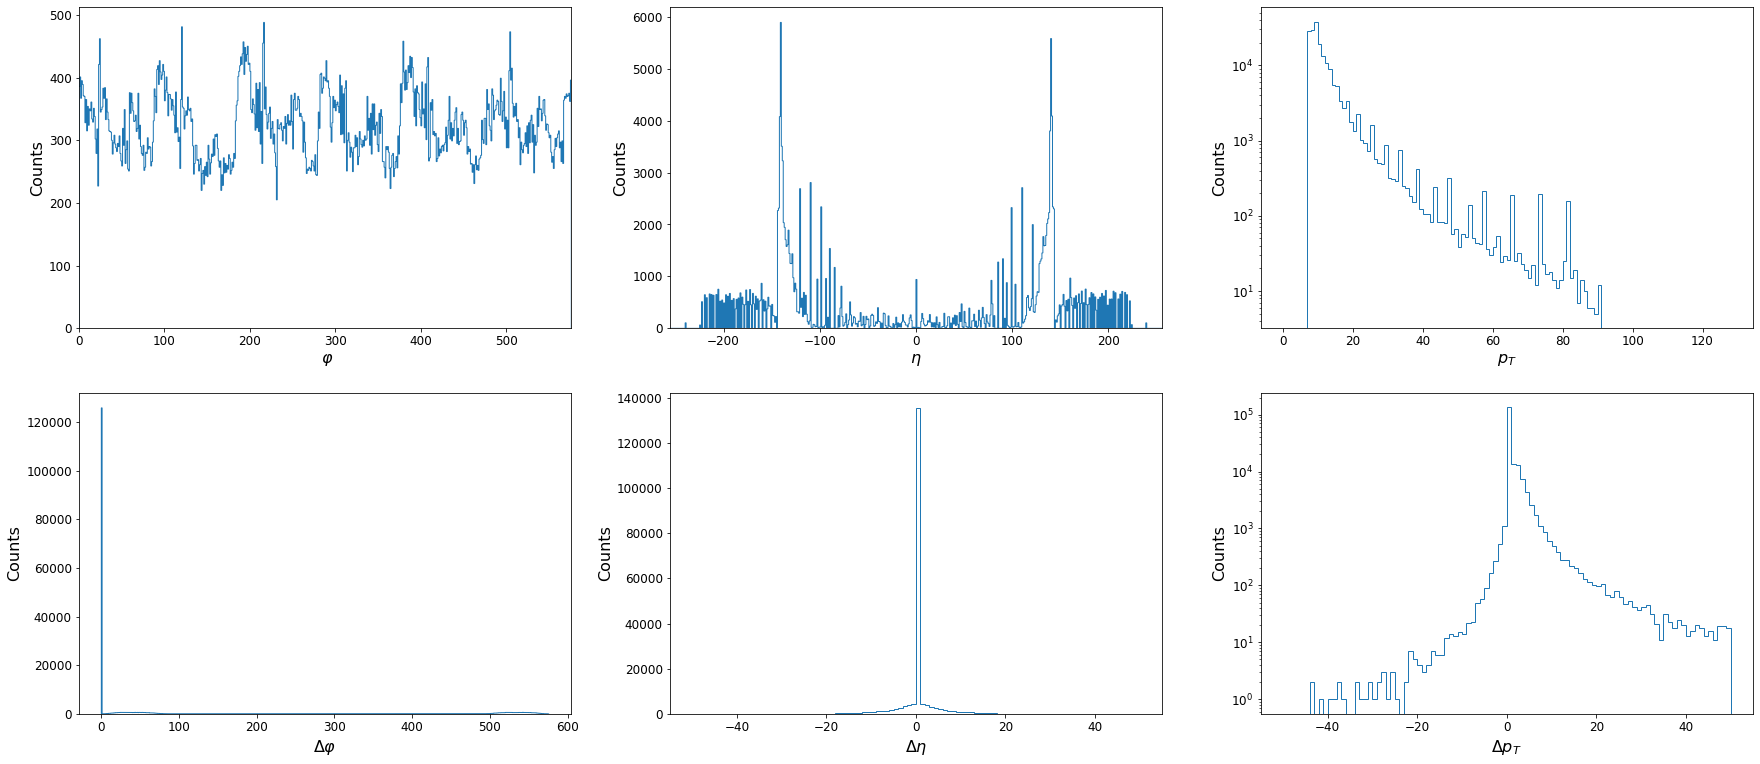

In [5]:
df_train =util.load_data(["/home/rardino/data/run3/run3golden_train_cl.csv"])
df_test = util.load_data(["/home/rardino/data/run3/run3golden_test.csv"])
# df_train = util.apply_cut(df_train, 5.5, 45)
# df_test = util.apply_cut(df_test, 5.5, 45)

x_train, y_train = util.preprocess_data(df_train)
x_test, y_test = util.preprocess_data(df_test)
util.plot_data(df_train)

In [6]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,):
        
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.sigmoid(teacher_predictions / self.temperature),
                    tf.nn.sigmoid(student_predictions / self.temperature),
                )* self.temperature**2)
            print(distillation_loss)
            print(student_loss)
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss


        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
    
    
    def predict_step(self, data):
        x, _, _ = data_adapter.unpack_x_y_sample_weight(data)
        return self.student(x, training=False)

In [7]:
#Making the teacher
model = m.make_model(hidden_neurons=teacher_hidden_neurons,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed,
                     sigmoid = False
                    )

if pruning:
    pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(target_sparsity, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

opt          = Adam(learning_rate=lr)

2023-10-07 18:28:55.367081: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 18:28:56.565037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10393 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2023-10-07 18:28:56.566043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10407 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


In [8]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(y_train), 
                                     y=np.squeeze(y_train))
print(np.unique(class_weights))

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

[0.66448202 2.01992299]


In [9]:
class auc(tf.keras.callbacks.Callback):
    def __init__(self,x_test,y_test):
        super().__init__()
        self.x_test = x_test
        self.y_test = y_test
    
    def on_epoch_end(self, epoch, logs=None):
        y_pred =  self.model.predict(self.x_test)
        y_pred = np.array(tf.math.sigmoid(y_pred))
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred)
        auc = metrics.auc(fpr, tpr)
        print("The Validation Auc is",auc)

In [18]:
if train:
    early_stopping = EarlyStopping(
        monitor  = 'val_loss',
        patience = 20
    )
    reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                               factor=0.5,
                                                               patience=20,
                                                               verbose=1,
                                                               mode="min",
                                                               min_delta=0.0001,
                                                               cooldown=0,
                                                               min_lr=0)

    checkpoint = ModelCheckpoint(
        "./teacher.h5",
        monitor           = 'val_loss',
        verbose           = 1,
        save_best_only    = True,
        save_weights_only = False
    )

#     callbacks = [early_stopping, checkpoint,FWHM(x_test,y_test, df_test, True)]
    callbacks = [
        auc(x_test,y_test),
                 reduce_lr_on_plateu]


    callbacks.append(pruning_callbacks.UpdatePruningStep())

    with tf.device(f'/device:GPU:{device}'):    
            model.compile(
                loss         = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer    = opt,
#                 metrics = tf.keras.metrics.AUC()
            )

            history = model.fit(
                x_train, y_train,
                callbacks=callbacks,
                batch_size=batch_size,
                epochs=n_epochs,
                validation_data=(x_test,y_test),
                class_weight=class_weights_dict,
                shuffle=True,
                verbose = 1
                #callbacks = callbacks.callbacks
            )

Epoch 1/200
183/183 [==============================] - 4s 11ms/step - loss: 1.0691 - val_loss: 0.8501
The Validation Auc is 0.9320921712575898
Epoch 2/200
183/183 [==============================] - 1s 7ms/step - loss: 0.6300 - val_loss: 0.5355
The Validation Auc is 0.9501395498546052
Epoch 3/200
183/183 [==============================] - 1s 7ms/step - loss: 0.4546 - val_loss: 0.4327
The Validation Auc is 0.9505101482856433
Epoch 4/200
183/183 [==============================] - 1s 7ms/step - loss: 0.3713 - val_loss: 0.3626
The Validation Auc is 0.9530531012327161
Epoch 5/200
183/183 [==============================] - 1s 7ms/step - loss: 0.3273 - val_loss: 0.3181
The Validation Auc is 0.9575272165301105
Epoch 6/200
183/183 [==============================] - 1s 7ms/step - loss: 0.3069 - val_loss: 0.3577
The Validation Auc is 0.9577533699450131
Epoch 7/200
183/183 [==============================] - 1s 6ms/step - loss: 0.2928 - val_loss: 0.3096
The Validation Auc is 0.9544118559357633
Epoch

183/183 [==============================] - 1s 7ms/step - loss: 0.1970 - val_loss: 0.2276
The Validation Auc is 0.9685212208126945
Epoch 115/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1969 - val_loss: 0.2274
The Validation Auc is 0.9685691576534601
Epoch 116/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1974 - val_loss: 0.2253
The Validation Auc is 0.9688105548521171
Epoch 117/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1977 - val_loss: 0.2281
The Validation Auc is 0.9685521814798675
Epoch 118/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1970 - val_loss: 0.2285
The Validation Auc is 0.9685143383555046
Epoch 119/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1967 - val_loss: 0.2295
The Validation Auc is 0.9676383087818852
Epoch 120/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1967 - val_loss: 0.2340
The Validation Auc is 0.9683339024382878
Epoch 

183/183 [==============================] - 1s 7ms/step - loss: 0.1877 - val_loss: 0.2144
The Validation Auc is 0.9695100032663965
Epoch 171/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1890 - val_loss: 0.2187
The Validation Auc is 0.9694233165846355
Epoch 172/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1879 - val_loss: 0.2203
The Validation Auc is 0.9695211775618262
Epoch 173/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1880 - val_loss: 0.2239
The Validation Auc is 0.9696146739694966
Epoch 174/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1885 - val_loss: 0.2211
The Validation Auc is 0.9695594127424262
Epoch 175/200
183/183 [==============================] - 1s 7ms/step - loss: 0.1880 - val_loss: 0.2174
The Validation Auc is 0.969598532473935
Epoch 176/200
183/183 [==============================] - 1s 6ms/step - loss: 0.1878 - val_loss: 0.2191
The Validation Auc is 0.9697377048185596
Epoch 1

In [21]:
# model.save('teacher-classification/best')

2023-08-04 01:45:43.683288: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: teacher-classification/best/assets


In [10]:
teacher = tf.keras.models.load_model('teacher-classification/best/')

In [11]:
student_non_distilled = m.make_model(hidden_neurons=student_hidden_neurons,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed,
                      sigmoid=True)

In [12]:
if train:
    early_stopping = EarlyStopping(
        monitor  = 'val_loss',
        patience = 20
    )
    reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                               factor=0.5,
                                                               patience=20,
                                                               verbose=1,
                                                               mode="min",
                                                               min_delta=0.0001,
                                                               cooldown=0,
                                                               min_lr=0)

    checkpoint = ModelCheckpoint(
        "./teacher.h5",
        monitor           = 'val_loss',
        verbose           = 1,
        save_best_only    = True,
        save_weights_only = False
    )

#     callbacks = [early_stopping, checkpoint,FWHM(x_test,y_test, df_test, True)]
    callbacks = [
                 reduce_lr_on_plateu]


#     callbacks.append(pruning_callbacks.UpdatePruningStep())

    with tf.device(f'/device:GPU:{device}'):    
            student_non_distilled.compile(
                loss         = tf.keras.losses.BinaryCrossentropy(),
                optimizer    = opt,
                metrics = tf.keras.metrics.AUC()
            )

            history = student_non_distilled.fit(
                x_train, y_train,
                callbacks=callbacks,
                batch_size=batch_size,
                epochs=100,
                validation_data=(x_test,y_test),
                class_weight=class_weights_dict,
                shuffle=True,
                verbose = 1
                #callbacks = callbacks.callbacks
            )

2023-10-07 18:29:06.968547: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
183/183 [==============================] - 5s 11ms/step - loss: 0.5797 - auc: 0.8084 - val_loss: 0.5810 - val_auc: 0.8143
Epoch 2/100
183/183 [==============================] - 1s 7ms/step - loss: 0.4068 - auc: 0.8986 - val_loss: 0.4413 - val_auc: 0.9001
Epoch 3/100
183/183 [==============================] - 1s 7ms/step - loss: 0.3366 - auc: 0.9260 - val_loss: 0.3419 - val_auc: 0.9250
Epoch 4/100
183/183 [==============================] - 1s 7ms/step - loss: 0.3105 - auc: 0.9353 - val_loss: 0.3195 - val_auc: 0.9298
Epoch 5/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2969 - auc: 0.9409 - val_loss: 0.3138 - val_auc: 0.9336
Epoch 6/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2867 - auc: 0.9446 - val_loss: 0.2942 - val_auc: 0.9411
Epoch 7/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2741 - auc: 0.9492 - val_loss: 0.3020 - val_auc: 0.9483
Epoch 8/100
183/183 [==============================] - 1s 7ms/step -

183/183 [==============================] - 1s 7ms/step - loss: 0.2299 - auc: 0.9610 - val_loss: 0.2583 - val_auc: 0.9598
Epoch 63/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2295 - auc: 0.9609 - val_loss: 0.2538 - val_auc: 0.9596
Epoch 64/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2295 - auc: 0.9608 - val_loss: 0.2484 - val_auc: 0.9596
Epoch 65/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2285 - auc: 0.9611 - val_loss: 0.2503 - val_auc: 0.9600
Epoch 66/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2283 - auc: 0.9612 - val_loss: 0.2679 - val_auc: 0.9599
Epoch 67/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2282 - auc: 0.9613 - val_loss: 0.2461 - val_auc: 0.9599
Epoch 68/100
183/183 [==============================] - 1s 7ms/step - loss: 0.2282 - auc: 0.9612 - val_loss: 0.2739 - val_auc: 0.9594
Epoch 69/100
183/183 [==============================] - 1s 7ms/step - loss:

In [13]:
class auc_student(tf.keras.callbacks.Callback):
    def __init__(self,x_test,y_test):
        super().__init__()
        self.x_test = x_test
        self.y_test = y_test
    
    def on_epoch_end(self, epoch, logs=None):
        y_pred =  self.model.predict(self.x_test)
        y_pred = np.array(tf.math.sigmoid(y_pred))
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred)
        auc = metrics.auc(fpr, tpr)
        print("The Validation Auc is",auc)

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)

early_stopping = EarlyStopping(
    monitor  = 'val_student_loss',
    patience = 50
)
reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_student_loss",
                                                           factor=0.5,
                                                           patience=10,
                                                           verbose=1,
                                                           mode="auto",
                                                           min_delta=0.001,
                                                           cooldown=0,
                                                           min_lr=0)

checkpoint = ModelCheckpoint(
    MODELPATH + "/qmodel_hl_4__hn_128__qrelu__reg_0p0001l2__ep_20__bs_1024_checkpoint.h5",
    monitor           = 'val_student_loss',
    verbose           = 1,
    save_best_only    = True,
    save_weights_only = False
)


callbacks = [
    auc_student(x_test,y_test),
             reduce_lr_on_plateu
    ]

callbacks.append(pruning_callbacks.UpdatePruningStep())

with tf.device(f'/device:GPU:{device}'):    
    distiller.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics = [],
        student_loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence() ,
        alpha=distill_alpha,
        temperature=0.1
    )
#     Distill teacher to student
    distiller.fit(x_train, y_train,
                  callbacks=callbacks,
                  verbose = 1,
                  batch_size=batch_size,
                  validation_split=0.1,
                  epochs=500)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

2023-08-04 12:18:48.105807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
Tensor("mul:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("mul:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
165/165 [==============================] - 5s 11ms/step - student_loss: 0.3733 - distillation_loss: 0.0026 - val_student_loss: 0.3963
The Validation Auc is 0.8338322325142296
Epoch 2/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2661 - distillation_loss: 0.0020 - val_student_loss: 0.2653
The Validation Auc is 0.9243781461647161
Epoch 3/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2417 - distillation_loss: 0.0022 - val_student_loss: 0.2604
The Validation Auc is 0.9341354222089633
Epoch 4/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2362 - distillation_loss: 0.0021 - val_student_loss: 0.2568
The Validation Auc is 0.9478318223375135
Epoch 5/500
165/165

165/165 [==============================] - 1s 7ms/step - student_loss: 0.2080 - distillation_loss: 8.4445e-04 - val_student_loss: 0.2296
The Validation Auc is 0.9602778062007005
Epoch 85/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2082 - distillation_loss: 8.7380e-04 - val_student_loss: 0.2296
The Validation Auc is 0.9602723541253639
Epoch 86/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2085 - distillation_loss: 8.2496e-04 - val_student_loss: 0.2278
The Validation Auc is 0.960314370639881
Epoch 87/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2081 - distillation_loss: 8.5621e-04 - val_student_loss: 0.2280
The Validation Auc is 0.9603309519865213
Epoch 88/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2092 - distillation_loss: 8.7893e-04 - val_student_loss: 0.2276
The Validation Auc is 0.9602796321021853
Epoch 89/500
165/165 [==============================] - 1s 

165/165 [==============================] - 1s 7ms/step - student_loss: 0.2074 - distillation_loss: 8.3720e-04 - val_student_loss: 0.2283
The Validation Auc is 0.960332483499489
Epoch 167/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2078 - distillation_loss: 8.3224e-04 - val_student_loss: 0.2286
The Validation Auc is 0.9603331505492347
Epoch 168/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2095 - distillation_loss: 8.7564e-04 - val_student_loss: 0.2289
The Validation Auc is 0.9603267114065175
Epoch 169/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2084 - distillation_loss: 8.4311e-04 - val_student_loss: 0.2285
The Validation Auc is 0.9603244532734216
Epoch 170/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2078 - distillation_loss: 8.2989e-04 - val_student_loss: 0.2283
The Validation Auc is 0.9603349709092887
Epoch 171/500
165/165 [==============================] 

165/165 [==============================] - 1s 7ms/step - student_loss: 0.2092 - distillation_loss: 8.7899e-04 - val_student_loss: 0.2289
The Validation Auc is 0.9603134583818174
Epoch 208/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2093 - distillation_loss: 8.7086e-04 - val_student_loss: 0.2288
The Validation Auc is 0.9603275675575929
Epoch 209/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2086 - distillation_loss: 8.2661e-04 - val_student_loss: 0.2286
The Validation Auc is 0.9603233193581217
Epoch 210/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2075 - distillation_loss: 8.5043e-04 - val_student_loss: 0.2287
The Validation Auc is 0.9603289432178164
Epoch 211/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2074 - distillation_loss: 8.9181e-04 - val_student_loss: 0.2286
The Validation Auc is 0.9603261025417962
Epoch 212/500
165/165 [==============================]

165/165 [==============================] - 1s 7ms/step - student_loss: 0.2076 - distillation_loss: 8.6489e-04 - val_student_loss: 0.2286
The Validation Auc is 0.9603271498722381
Epoch 290/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2078 - distillation_loss: 8.8200e-04 - val_student_loss: 0.2283
The Validation Auc is 0.9603238714231761
Epoch 291/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2082 - distillation_loss: 8.7354e-04 - val_student_loss: 0.2289
The Validation Auc is 0.9603223579198588
Epoch 292/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2077 - distillation_loss: 8.4809e-04 - val_student_loss: 0.2287
The Validation Auc is 0.9603264447251547
Epoch 293/500
165/165 [==============================] - 1s 7ms/step - student_loss: 0.2078 - distillation_loss: 8.3459e-04 - val_student_loss: 0.2285
The Validation Auc is 0.9603314576420918

Epoch 00293: ReduceLROnPlateau reducing learning rate

In [14]:
student_distilled = tf.keras.models.load_model('student-classification/best/')

In [22]:
y_pred_teacher =  teacher.predict(x_test)
y_pred_teacher = np.array(tf.math.sigmoid(y_pred_teacher))
fpr_teacher, tpr_teacher, thresholds = roc_curve(y_test, y_pred_teacher)
auc_teacher = metrics.auc(fpr_teacher, tpr_teacher)

y_pred_student_non_distilled =  student_non_distilled.predict(x_test)
y_pred_student_non_distilled = np.array(tf.math.sigmoid(y_pred_student_non_distilled))
fpr_student_non_distilled, tpr_student_non_distilled, thresholds = roc_curve(y_test, y_pred_student_non_distilled)
auc_student_non_distilled = metrics.auc(fpr_student_non_distilled, tpr_student_non_distilled)

y_pred_student_distilled =  student_distilled.predict(x_test)
y_pred_student_distilled = np.array(tf.math.sigmoid(y_pred_student_distilled))
fpr_student_distilled, tpr_student_distilled, thresholds = roc_curve(y_test, y_pred_student_distilled)
auc_student_distilled = metrics.auc(fpr_student_distilled, tpr_student_distilled)




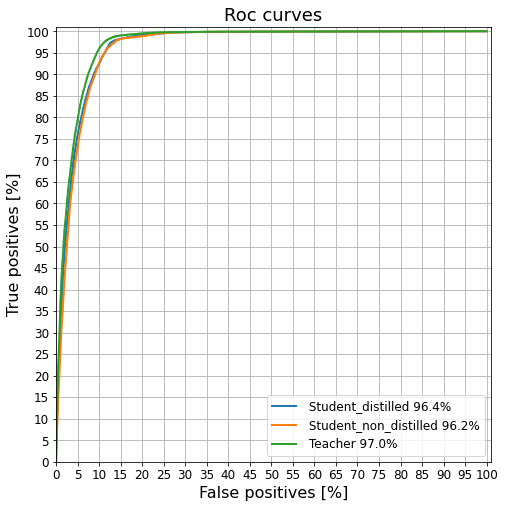

In [41]:
f = plt.figure(figsize=(16,8))
plt.plot(100*fpr_student_distilled, 100*tpr_student_distilled, linewidth=2, label='%s Student_distilled %.1f%%'%('', auc_student_distilled*100.))
plt.plot(100*fpr_student_non_distilled, 100*tpr_student_non_distilled, linewidth=2, label='%s Student_non_distilled %.1f%%'%('', auc_student_non_distilled*100.))
plt.plot(100*fpr_teacher, 100*tpr_teacher, linewidth=2, label='%s Teacher %.1f%%'%('', auc_teacher*100.))

plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.legend()
plt.legend(loc='lower right')
plt.xlim([0,101])
plt.ylim([0,101])
plt.title('Roc curves')
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xticks(range(0,101,5))
ax.set_yticks(range(0,101,5))
plt.savefig("roc_dim.pdf",bbox_inches='tight')
plt.show()


In [24]:
precision_teacher, recall_teacher, thresholds = precision_recall_curve(y_test, y_pred_teacher)
auc_teacher_pr = metrics.auc(recall_teacher, precision_teacher)

precision_student_non_distilled, recall_student_non_distilled, thresholds = precision_recall_curve(y_test, y_pred_student_non_distilled)
auc_student_non_distilled_pr = metrics.auc(recall_student_non_distilled, precision_student_non_distilled)

precision_student_distilled, recall_student_distilled, thresholds = precision_recall_curve(y_test, y_pred_student_distilled)
auc_student_distilled_pr = metrics.auc(recall_student_distilled, precision_student_distilled)

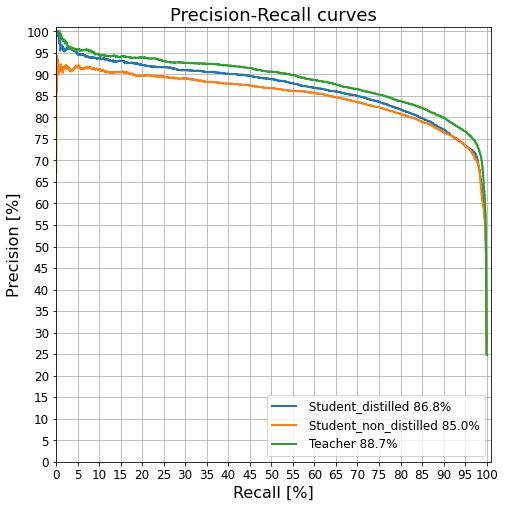

In [42]:
f = plt.figure(figsize=(16,8))
plt.plot(100*recall_student_distilled, 100*precision_student_distilled, linewidth=2, label='%s Student_distilled %.1f%%'%('', auc_student_distilled_pr*100.))
plt.plot(100*recall_student_non_distilled, 100*precision_student_non_distilled, linewidth=2, label='%s Student_non_distilled %.1f%%'%('', auc_student_non_distilled_pr*100.))
plt.plot(100*recall_teacher, 100*precision_teacher, linewidth=2, label='%s Teacher %.1f%%'%('', auc_teacher_pr*100.))

plt.xlabel('Recall [%]')
plt.ylabel('Precision [%]')
plt.legend()
plt.legend(loc='lower right')
plt.xlim([0,101])
plt.ylim([0,101])
plt.title('Precision-Recall curves')
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')
ax.set_xticks(range(0,101,5))
ax.set_yticks(range(0,101,5))
plt.savefig("pr_dim.pdf",bbox_inches='tight')
plt.show()

In [34]:
config = hls4ml.utils.config_from_keras_model(student_distilled, granularity='model')
config["Model"]["Precision"] = "ap_fixed<18,6>"
config['Model']['ReuseFactor'] = 4
c_config = hls4ml.converters.create_config(project_name ='nn_ugmt_classifiaction_run3',
                                           output_dir="tmp/hls4ml_test",
                                           clock_period=4,
                                           part='xcvu37p-fsvh2892-2L-e',
                                           backend='Vivado')
c_config['HLSConfig'] = config
c_config['KerasModel'] = student_distilled
hls_model = hls4ml.converters.convert_from_config(c_config)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: hd1_input, layer type: InputLayer, input shapes: [[None, 10]], output shape: [None, 10]
Layer name: hd1, layer type: QDense, input shapes: [[None, 10]], output shape: [None, 8]
Layer name: bn1, layer type: QBatchNormalization, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: act1, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: hd2, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: bn2, layer type: QBatchNormalization, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: act2, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: hd3, layer type: QDense, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: bn3, layer type: QBatchNormalization, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: act3, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
Layer name: hd4, la

In [37]:
y_pred_hls =  hls_model.predict(np.ascontiguousarray(x_test))
y_pred_hls = np.array(tf.math.sigmoid(y_pred_hls))
fpr_hls, tpr_hls, thresholds = roc_curve(y_test, y_pred_hls)
auc_hls = metrics.auc(fpr_hls, tpr_hls)

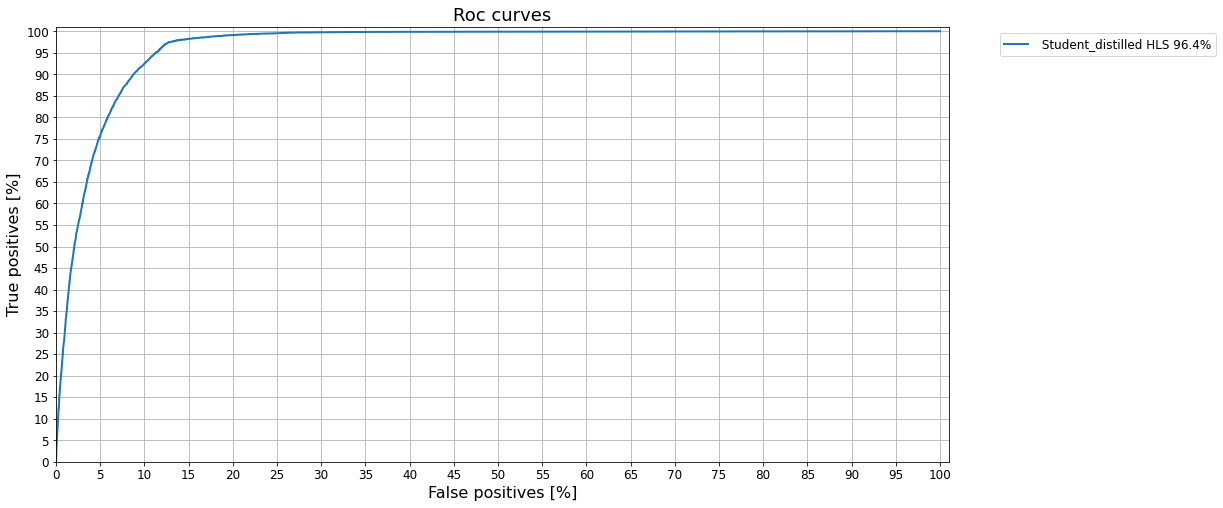

In [43]:
f = plt.figure(figsize=(16,8))
plt.plot(100*fpr_hls, 100*tpr_hls, linewidth=2, label='%s Student_distilled HLS %.1f%%'%('', auc_hls*100.))

plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim([0,101])
plt.ylim([0,101])
plt.title('Roc curves')
plt.grid(True)
ax = plt.gca()
# ax.set_aspect('equal')
ax.set_xticks(range(0,101,5))
ax.set_yticks(range(0,101,5))
# plt.savefig("roc_dim_hls.pdf")
plt.show()

In [44]:
os.environ["OMP_NUM_THREADS"] = "10"
os.environ['PATH'] = '/home/xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
os.environ['LD_LIBRARY_PATH'] = '/usr/lib64'

hls_logs = hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/home/xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'diptarko' on host 'pcgpu-c2f07-18-01.cern.ch' (Linux_x86_64 version 4.18.0-497.el8.x86_64) on Sat Oct 07 16:47:15 CEST 2023
INFO: [HLS 200-10] On os "CentOS Stream release 8"
INFO: [HLS 200-10] In directory '/home/diptarko/Classification/tmp/hls4ml_test'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/diptarko/Classification/tmp/hls4ml_test/nn_ugmt_classifiaction_run3_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/nn_ugmt_classifiaction_run3.cpp' to the project
INFO: [HLS 200-10] Adding test benc

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:22 ; elapsed = 00:00:23 . Memory (MB): peak = 885.367 ; gain = 463.156 ; free physical = 54500 ; free virtual = 270177
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18>' (firmware/nnet_utils/nnet_dense_latency.h:13:43).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, relu_config17>' (firmware/nnet_utils/nnet_activation.h:40:43).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>' (firmware/nnet_utils/nnet_batchnorm.h:37:47).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::de

INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:40) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:48) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 8.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:54) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 10.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:56) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_ugmt_classifiaction_run3.cpp:91) by setting 'bias[6].V' to 'b16.V.6'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_ugmt_classifiaction_run3.cpp:91) by setting 'bias[7].V' to 'b16.V.7'.
INFO: [XFO

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_ugmt_classifiaction_run3.cpp:79) by setting 'bias[4].V' to 'b12.V.4'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_ugmt_classifiaction_run3.cpp:79) by setting 'bias[5].V' to 'b12.V.5'.
INFO: [XFORM 203-622] Inst

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_ugmt_classifiaction_run3.cpp:67) by setting 'bias[1].V' to 'b8.V.1'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nn_ugmt_classifiaction_run3.cpp:67) by setting 'bias[2].V' to 'b8.V.2'.
INFO: [XFORM 203-622] Instantiating function 'nnet::norm

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0' at call site (firmware/nn_ugmt_classifiaction_run3.cpp:55) by setting 'scale[5].V' to 's4.V.5'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0' at call site (firmware/nn_ugmt_classifiaction_run3.cpp:55) by setting 'scale[6].V' to 's4.V.6'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mo

INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0.0.0.0.0.0.0.0' (firmware/nnet_utils/nnet_dense_latency.h:26:1)...63 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0' (firmware/nnet_utils/nnet_dense_latency.h:26:1)...80 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18>.0.0' (firmware/nnet_utils/nnet_dense_latency.h:26:1)...8 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>.0

INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed,ap_fixed<18,6,5,3,0>,config2>.0.0.0.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 4, Final II = 4, Depth = 4.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 29.48 seconds; current allocated memory: 275.906 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.36 seconds; current allocated memory: 277.323 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'normalize_ap_fixed_ap_fixed_config4_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] -------------------------------------------------------

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.08 seconds; current allocated memory: 284.060 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_ap_fixed_ap_fixed_18_6_5_3_0_config14_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed,ap_fixed<18,6,5,3,0>,config14>.0.0.0.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 4, Final II = 4, Depth = 4.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.38 seconds; current allocated memory: 285.001 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Bind

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_ap_fixed_ap_fixed_18_6_5_3_0_config10_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_ap_fixed_ap_fixed_18_6_5_3_0_config10_0_0_0_0_0_0_0_0_0'.
INFO: [HLS 200-111]  Elapsed time: 0.33 seconds; current allocated memory: 308.770 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'normalize_ap_fixed_ap_fixed_config12_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'normalize_ap_fixed_ap_fixed_config12_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0'.
INFO: [HLS 200-111]  Elapsed time: 0.83 seconds; current allocated memory: 313.474 

In [45]:
hls_logs

{'CSynthesisReport': {'TargetClockPeriod': '4.00',
  'EstimatedClockPeriod': '3.397',
  'BestLatency': '39',
  'WorstLatency': '39',
  'IntervalMin': '4',
  'IntervalMax': '4',
  'DSP': '78',
  'FF': '6110',
  'LUT': '12283',
  'BRAM_18K': '0',
  'URAM': '0',
  'AvailableBRAM_18K': '4032',
  'AvailableDSP': '9024',
  'AvailableFF': '2607360',
  'AvailableLUT': '1303680',
  'AvailableURAM': '960'}}